# Sommaire :
**Partie 0 : Mise en place de environnement**
 - <a href="#C1">Importation des librairies</a>
 - <a href="#C2">Définition des fonctions</a>
 - <a href="#C3">Importation du jeu de données</a>
 
**Partie 1 : Analyse des données**
 - <a href="#C4">Apercu et nettoyage initial des fichiers</a>
 - <a href="#C5">Analyse de la cible TARGET</a>
 - <a href="#C6">Création d'un dataset simple</a>
 - <a href="#C7">Création d'un dataset à partir du Kernel</a>

**Partie 2 : Modélisation**
 - <a href="#C8">Echantillon et Separation des donnees</a>
 - <a href="#C9">Pré-traitement et modélisation</a>
 - <a href="#C10">Optmisation des gains</a>
 - <a href="#C11">Interprétabilité du modèle </a>
 
**Partie 3 : Dashboard**
 - <a href="#C12">Deploiment du modèle</a>

# Partie 0 : Mise en place de l'environnement

# <a name="C1">Importation des librairies</a>

In [1]:
#import des librairies
import pandas as pd
from pandas import DataFrame
import numpy as np
import missingno as msno

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import gc
import time

from contextlib import contextmanager

from lightgbm import LGBMClassifier
import sklearn as skl
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc, fbeta_score, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re

C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\najwa\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas

In [2]:
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling  import RandomUnderSampler

from collections import Counter

import math

import lightgbm as lgb
from lightgbm import LGBMClassifier
import re

import shap


In [3]:
#versions des librairies utilisées
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)
print("sklearn version : " + skl.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2
sklearn version : 1.0.2


# <a name="C2">Définition des fonctions</a>

In [4]:
PATH = "Datasource/"

In [5]:
sampler_list = [RandomUnderSampler(random_state=14), SMOTE(random_state=14)] 
    
scaler_list = [MinMaxScaler(feature_range=(0, 1)), StandardScaler(), RobustScaler()]                                         

In [6]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [7]:
# One-hot encoding for categorical columns with get_dummies 
def one_hot_encoder(df, nan_as_category = True):
    '''Fonction du kernel Kaggle'''                                 

    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
# Preprocess application_train.csv and application_test.csv [fonction du Kernel Kaggle]
def application_train_test(num_rows = None, nan_as_category = False):
    '''Fonction du kernel Kaggle'''     
    
    # Read data and merge
    df = pd.read_csv(PATH+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(PATH+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [9]:
# Preprocess bureau.csv and bureau_balance.csv [fonction du Kernel Kaggle]
def bureau_and_balance(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''     
    
    bureau = pd.read_csv(PATH+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(PATH+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [10]:
# Preprocess previous_applications.csv [fonction du Kernel Kaggle]
def previous_applications(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''     
    
    prev = pd.read_csv(PATH+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [11]:
# Preprocess POS_CASH_balance.csv [fonction du Kernel Kaggle]
def pos_cash(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''     
    
    pos = pd.read_csv(PATH+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [12]:
# Preprocess installments_payments.csv [fonction du Kernel Kaggle]
def installments_payments(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''     
    
    ins = pd.read_csv(PATH+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [13]:
# Preprocess credit_card_balance.csv [fonction du Kernel Kaggle]
def credit_card_balance(num_rows = None, nan_as_category = True):
    '''Fonction du kernel Kaggle'''     
    
    cc = pd.read_csv(PATH+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [14]:
# LightGBM GBDT with KFold or Stratified KFold [fonction du Kernel Kaggle]
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    '''Fonction du kernel Kaggle'''     
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [15]:
# Display/plot feature importance [fonction du Kernel Kaggle]
def display_importances(feature_importance_df_):
    '''Fonction du kernel Kaggle'''     
    
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [16]:
#Main [fonction du Kernel Kaggle]
def main(debug = False): 
    '''Fonction du kernel Kaggle'''     
    
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    
    return df

In [17]:
def undersampling_manuel(X_train, y_train):
    '''Fonction manuelle d'equilibrage des classes'''                                 

    targ1 = y_train[y_train==1].index
    targ0 = y_train[y_train==0].sample(len(targ1)).index
    
    samp_ind = list(set(list(targ0)+list(targ1)))
    
    X_tr_undersamp = X_train.loc[samp_ind]
    y_tr_undersamp = y_train.loc[samp_ind]
    
    return X_tr_undersamp, y_tr_undersamp

In [18]:
from imblearn.pipeline import Pipeline
def modelisation_with_sampler(X_train, y_train, sampler_type, estimator):
    '''Fonction de pré-traitement qui retourne pour un algo, le résultat des différents pré-traitements - avec sampler'''                                 
                                               
    param_grid = {
        'sampler' : sampler_list,
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('sampler', RandomUnderSampler(random_state=14)),
        ('scaler', MinMaxScaler(feature_range=(0, 1))), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc")

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [19]:
from imblearn.pipeline import Pipeline
def modelisation_no_sampler(X_train, y_train, sampler_type, estimator):
    '''Fonction de pré-traitement qui retourne pour un algo, le résultat des différents pré-traitements - sans sampler'''                                 
                                               
    param_grid = {
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('scaler', MinMaxScaler(feature_range=(0, 1))), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc")

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [20]:
def modelisation_baseline(X_train, y_train, sampler_type, estimator):
    '''Fonction de pré-traitement qui retourne pour un algo, le résultat des différents pré-traitements - pour baseline'''                                 
                                               
    param_grid = {
        'scaler' : scaler_list,
    }

    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)), # Imputation des valeurs manquantes par la mediane
        ('scaler', StandardScaler()), # Mise à l'échelle des valeurs
        ('estimator', estimator)
    ])

    grid = GridSearchCV(pipeline, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3)

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['sampler_type'] = sampler_type
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','sampler_type','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [21]:
from imblearn.pipeline import Pipeline
def optimisation_modele(X_train, y_train, estimator):
    '''Fonction d'optimisationd des hyperparametres de LGBM'''
                                                
    param_grid = {
        'n_estimators' : [1000, 5000, 10000],
        'learning_rate' : [1, 0.1, 0.01] 
        }
        
    grid = GridSearchCV(estimator, param_grid = param_grid, cv=5, n_jobs=-1, verbose=3, scoring="roc_auc", return_train_score = True)

    grid.fit(X_train, y_train)
    
    y_proba_train = grid.predict_proba(X_train)
    y_proba_test = grid.predict_proba(X_test)
    y_pred_test = grid.predict(X_test)

    result = pd.DataFrame(grid.cv_results_)
    result['estimator'] = estimator
    result['accuracy'] = round(accuracy_score(y_test, y_pred_test),3)
    result['precision'] = round(precision_score(y_test, y_pred_test, average='binary'),3)
    result['recall'] = round(recall_score(y_test, y_pred_test, average='binary'),3)
    result['f1score'] = round(f1_score(y_test, y_pred_test, average='binary'),3)
    result['auc'] = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
    result = result[['estimator','params','mean_test_score','mean_fit_time','accuracy','precision','recall', 'f1score','auc']]

    return result

In [22]:
def matrice_roc_auc(y_true, y_pred, y_pred_proba, size):
    '''Fonction d'affichage de la matrice de confusion et de ROC/AUC, et retourne les predictions'''

    fig = plt.figure(figsize=size)
  
    #Afficher matric de confusion
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Matrice de confusion')
    cf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #labels = ['Classe: 0', 'Classe: 1']
    
    sns.heatmap(cf_matrix, annot=labels, fmt="")
    
    #Afficher AUC/ROC
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba[:,1])    #pour la courbe ROC utilisation de la probabiilité d'être 1
    plt.plot(fpr, tpr, color='darkgreen', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()

    return tn, fp, fn, tp

In [23]:
def gain_banque(TN, FP, FN, TP, coeff_TN, coeff_FP, coeff_FN, coeff_TP):
    '''Fonction de cout ou gain de la banque, en fonction des predictions et coeff de cout/profit associe'''

    gain = (coeff_TN*TN + coeff_FP*FP + coeff_FN*FN + coeff_TP*TP)

    #Calcul du gain maximal
    max_gain = (TN + FP)*coeff_TN 

    #Calcul du gain minimal 
    min_gain = (TP + FN)*coeff_FN

    #Normalisation de la focntion de gain : 
    f_gain = (gain - min_gain)/(max_gain - min_gain)

    return f_gain

# <a name="C3">Importation du jeu de données</a>

In [24]:
#import des 9 fichiers constituant le jeu de données
df_test = pd.read_csv(PATH+'application_test.csv')
df_train = pd.read_csv(PATH+'application_train.csv')
df_train_or = df_train.copy()
bureau = pd.read_csv(PATH+'bureau.csv')
bureau_balance = pd.read_csv(PATH+'bureau_balance.csv')
previous_app = pd.read_csv(PATH+'previous_application.csv')
homecredit_desc = pd.read_csv(PATH+'HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
sampl_submission = pd.read_csv(PATH+'sample_submission.csv')
cash_balance = pd.read_csv(PATH+'POS_CASH_balance.csv')
cc_balance = pd.read_csv(PATH+'credit_card_balance.csv')
inst_payments = pd.read_csv(PATH+'installments_payments.csv')

In [25]:
#Création de listes
df_liste = [df_test, df_train, bureau, bureau_balance, previous_app, homecredit_desc, sampl_submission, cash_balance, cc_balance, inst_payments]
df_noms = ['df_test', 'df_train', 'bureau', 'bureau_balance', 'previous_app', 'homecredit_desc', 'sampl_submission', 'cash_balance', 'cc_balance', 'inst_payments']

# Partie 1 : Analyse des données

# <a name="C4">Apercu et nettoyage initial des fichiers</a>

In [92]:
#Affichage des 2 premieres lignes pour s'assurer de l'import.
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.head(2))
    print('\n')

df_test :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0




df_train :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0




bureau :


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN




bureau_balance :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C




previous_app :


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0




homecredit_desc :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN




sampl_submission :


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5




cash_balance :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0




cc_balance :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0




inst_payments :


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


In [93]:
#Affichage de la taille de chaque fichier
for df, nom in zip(df_liste, df_noms):
    print(nom, ':', df.shape)

df_test : (48744, 121)
df_train : (307511, 122)
bureau : (1716428, 17)
bureau_balance : (27299925, 3)
previous_app : (1670214, 37)
homecredit_desc : (219, 5)
sampl_submission : (48744, 2)
cash_balance : (10001358, 8)
cc_balance : (3840312, 23)
inst_payments : (13605401, 8)


In [94]:
#Aperçu des colonnes
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.info())

df_test :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


None

df_train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

bureau :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


None

bureau_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


None

previous_app :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT          

None

homecredit_desc :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


None

sampl_submission :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


None

cash_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


None

cc_balance :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INST

None

inst_payments :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


None

In [95]:
#Recherche des doublons
for df, nom in zip(df_liste, df_noms):
    print(nom, df.duplicated().sum())

df_test 0
df_train 0
bureau 0
bureau_balance 0
previous_app 0
homecredit_desc 0
sampl_submission 0
cash_balance 0
cc_balance 0
inst_payments 0


In [96]:
#Aperçu des données manquantes pour chaque fichier (% de NaN)
for df, nom in zip(df_liste, df_noms):
    print(nom, df.isna().mean().mean())

df_test 0.23811686761532344
df_train 0.24395941907129431
bureau 0.13502552290879322
bureau_balance 0.0
previous_app 0.17976877473444977
homecredit_desc 0.12146118721461188
sampl_submission 0.0
cash_balance 0.0006518864738168557
cc_balance 0.0665407439268748
inst_payments 5.337953655316738e-05


# <a name="C5">Analyse de la cible TARGET</a>

In [107]:
#Nombre de clients dans chaque classe
df_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

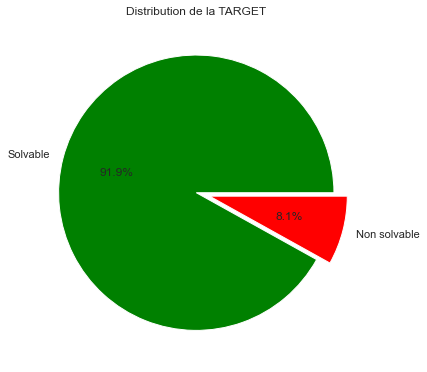

In [108]:
#Visualisation de la distribution de la TARGET
y = ['Solvable', 'Non solvable']
x = df_train["TARGET"].value_counts()
colors_list = ['green', 'red']
explode_val = (0,0.1)
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(x, labels = y, autopct ='%.1f%%', explode = explode_val, colors = colors_list)
ax.set_title("Distribution de la TARGET")
plt.tight_layout()

# <a name="C6">Création d'un dataset simple</a>

In [109]:
#Affichage des 2 premieres lignes pour s'assurer de l'import.
df_train.head(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
#Taille du fichier data
df_train.shape

(307511, 54)

In [111]:
#Aperçu des colonnes
print(list(df_train.columns))

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT

In [112]:
#Nombre de variables par type
df_train.dtypes.value_counts()

int64      41
float64    13
dtype: int64

In [113]:
#Retrait des colonnes catégorielles
df_train.drop(df_train.select_dtypes('object').columns,1,inplace=True)

In [114]:
#Aperçu valeurs manquantes
df_train.isna().mean()

SK_ID_CURR                     0.000000
TARGET                         0.000000
CNT_CHILDREN                   0.000000
AMT_INCOME_TOTAL               0.000000
AMT_CREDIT                     0.000000
AMT_ANNUITY                    0.000039
AMT_GOODS_PRICE                0.000904
REGION_POPULATION_RELATIVE     0.000000
DAYS_BIRTH                     0.000000
DAYS_EMPLOYED                  0.000000
DAYS_REGISTRATION              0.000000
DAYS_ID_PUBLISH                0.000000
FLAG_MOBIL                     0.000000
FLAG_EMP_PHONE                 0.000000
FLAG_WORK_PHONE                0.000000
FLAG_CONT_MOBILE               0.000000
FLAG_PHONE                     0.000000
FLAG_EMAIL                     0.000000
CNT_FAM_MEMBERS                0.000007
REGION_RATING_CLIENT           0.000000
REGION_RATING_CLIENT_W_CITY    0.000000
HOUR_APPR_PROCESS_START        0.000000
REG_REGION_NOT_LIVE_REGION     0.000000
REG_REGION_NOT_WORK_REGION     0.000000
LIVE_REGION_NOT_WORK_REGION    0.000000


<AxesSubplot:>

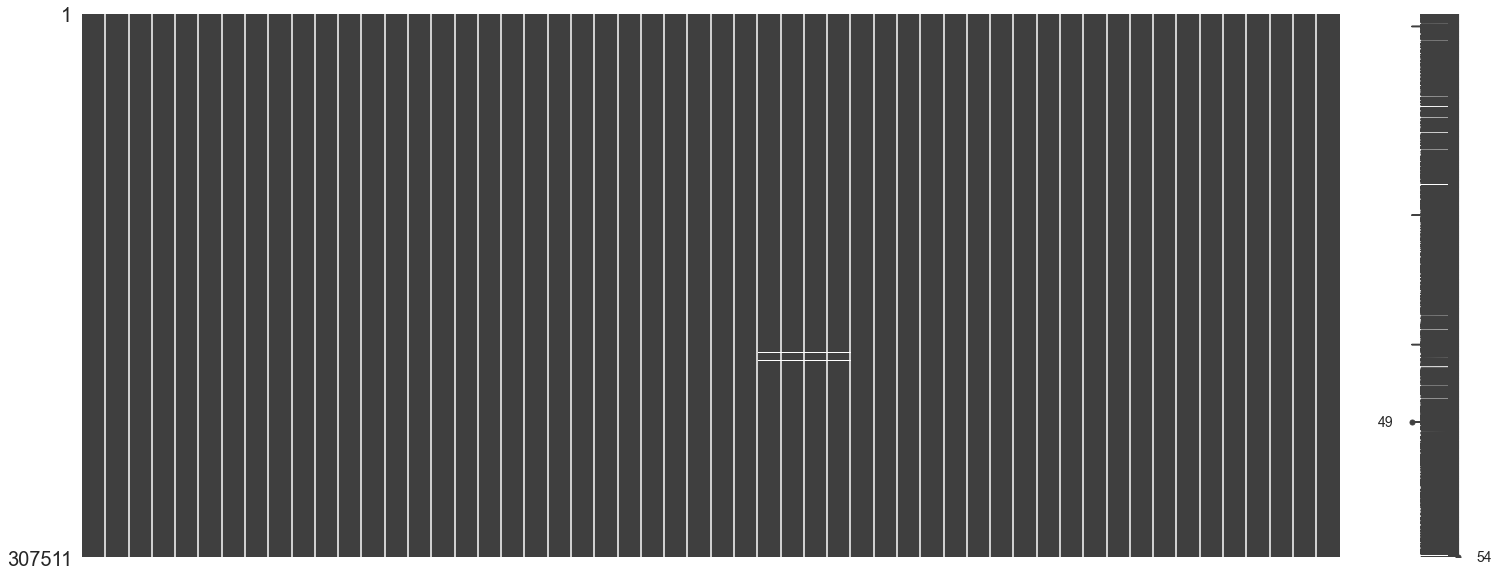

In [115]:
#Aperçu des données manquantes pour le fichier app (% de NaN)
msno.matrix(df_train)

In [116]:
#Suppression des variables ayant plus de 10% de NaN
df_train = df_train[df_train.columns[df_train.isna().sum()/df_train.shape[0]<0.1]]
df_train.shape

(307511, 54)

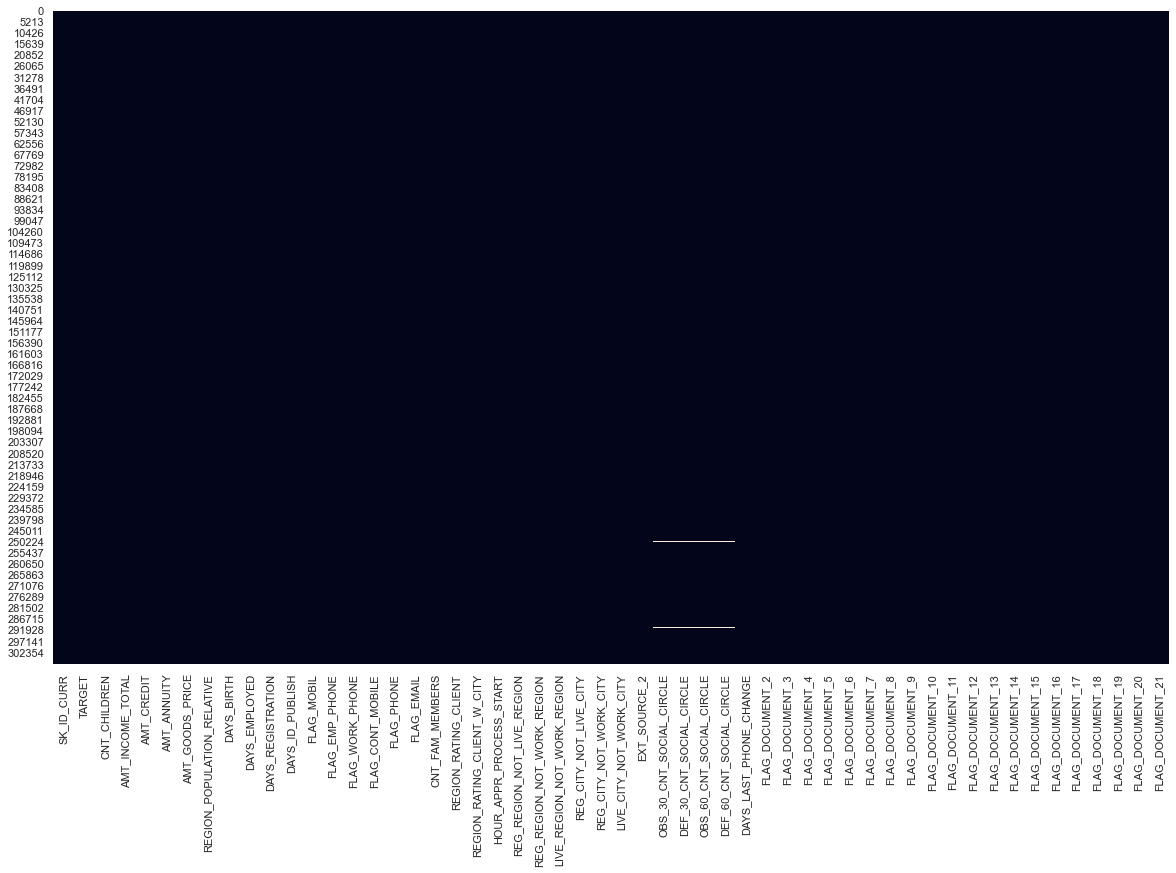

In [117]:
#Visualisation des données manquantes
plt.figure(figsize=(20,12))
sns.heatmap(df_train.isna(), cbar= False)
plt.show()

In [119]:
#Affichage des stats sur les variables
pd.pandas.set_option('display.max_columns', None)
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.068510e+05,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,5.143927e-01,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,1.910602e-01,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.924574e-01,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-325

In [120]:
#Analyse et visualisation de la Target et des variables avec outliers ou dont les valeurs sont innatendues
COL_TARGET = ['TARGET']
COL_FEATURES_AB = ['AMT_INCOME_TOTAL','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']
COL = COL_TARGET + COL_FEATURES_AB
COL

['TARGET',
 'AMT_INCOME_TOTAL',
 'AMT_ANNUITY',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

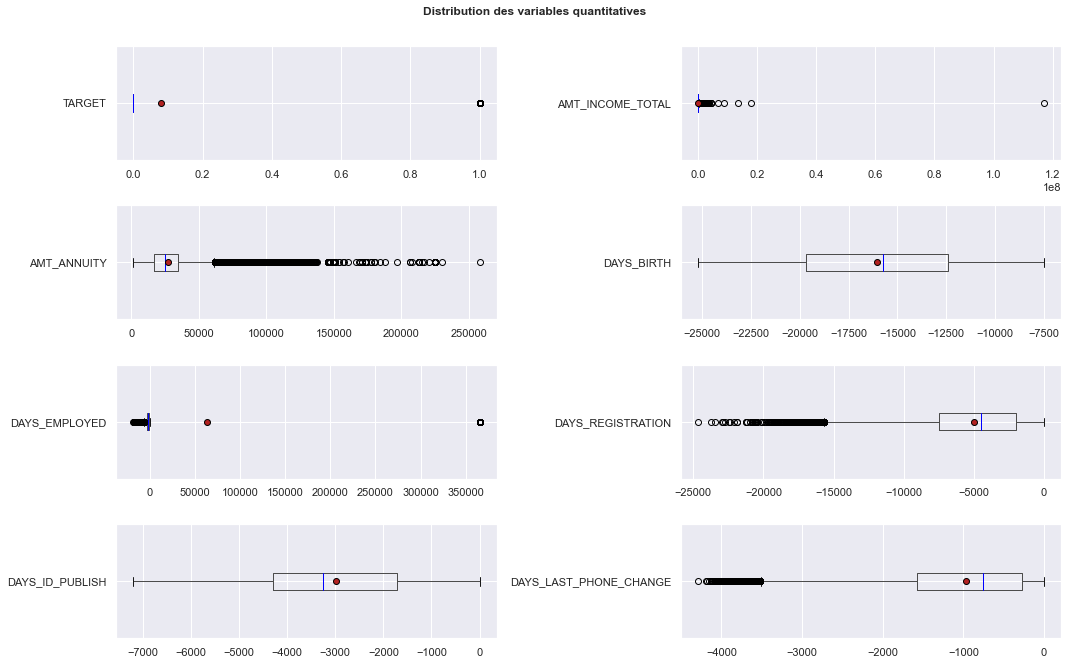

In [121]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    data_temp = df_train[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

In [122]:
#Identification des outliers AMT_INCOME
df_train[df_train.AMT_INCOME_TOTAL>1e8]

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
12840,114967,1,1,117000000.0,562491.0,26194.5,454500.0,0.010643,-12615,-922,-6762.0,-3643,1,1,0,1,0,0,3.0,2,2,14,0,0,0,0,0,0,0.113161,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
#Suppression de cette outliers compte tenu de leur faible nombre
df_train = df_train[df_train.AMT_INCOME_TOTAL<1e8]

In [124]:
#Identification des outliers DAYS_EMPLOYED
OUT = df_train[df_train['DAYS_EMPLOYED'] > 300000]
OUT['DAYS_EMPLOYED']

8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

In [125]:
#Mise à jour de l'outlier en NaN compte tenu du nombre d'occurences
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243,np.nan)

In [126]:
#Changement de DAYS_BIRTH de jours à années
df_train['DAYS_BIRTH'] = df_train['DAYS_BIRTH'] / -365
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'] / -365
df_train['DAYS_REGISTRATION'] = df_train['DAYS_REGISTRATION'] / -365
df_train['DAYS_ID_PUBLISH'] = df_train['DAYS_ID_PUBLISH'] / -365
df_train['DAYS_LAST_PHONE_CHANGE'] = df_train['DAYS_LAST_PHONE_CHANGE'] / -365
df_train['AMT_ANNUITY'] = df_train['AMT_ANNUITY'] 

In [127]:
#Taille du jeu
df_train.shape

(307510, 54)

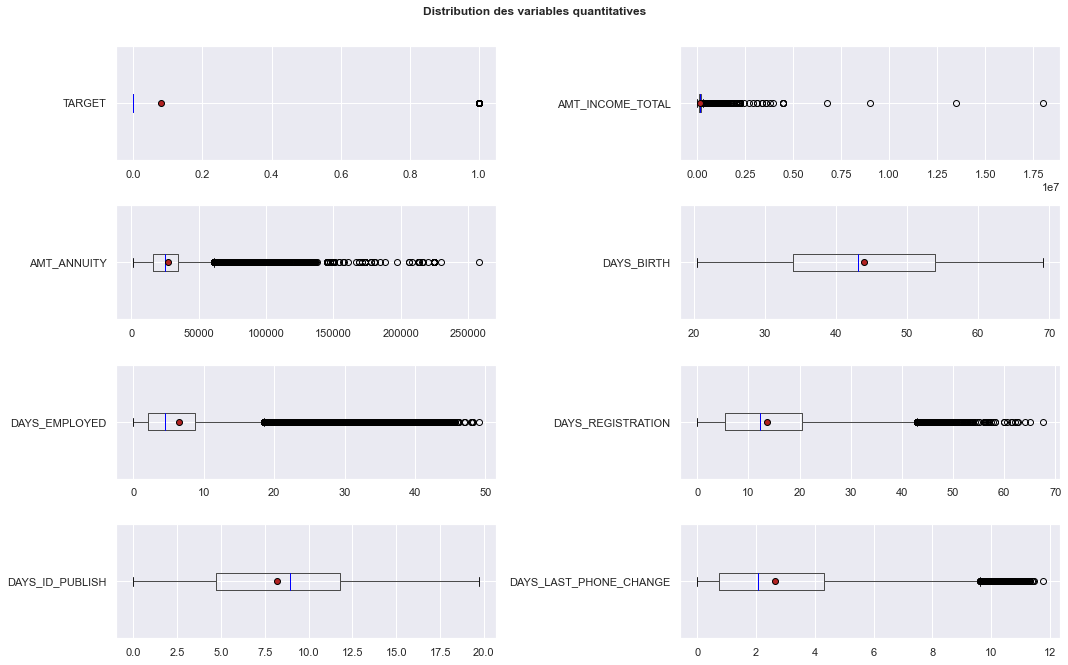

In [128]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    data_temp = df_train[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

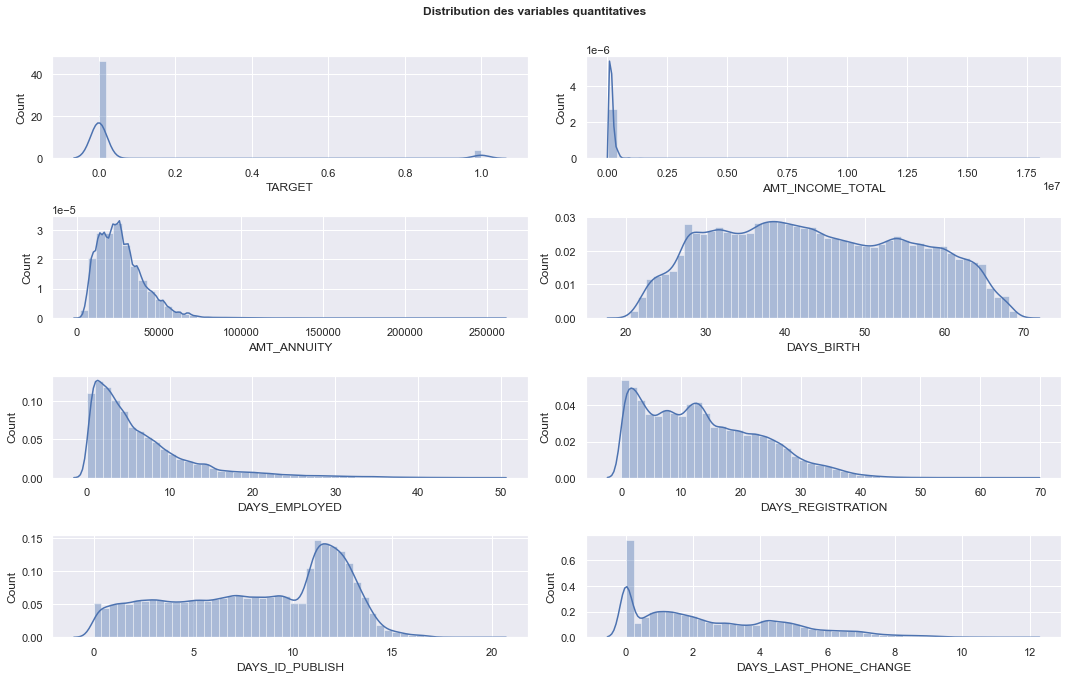

In [129]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(5,2,i)
    sns.distplot(df_train[col])
    plt.xlabel(col)
    plt.ylabel("Count")
    
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

In [130]:
df_train.shape

(307510, 54)

In [131]:
#Suppression des lignes avec un NaN
df_train = df_train.dropna()
df_train.shape

(250518, 54)

In [132]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FL

In [133]:
df_train['NB_DOCUMENTS']=(df_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=1)
df_train.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],1, inplace=True)

In [134]:
#Either remove or create new feature not to loose info
 # Sum of contact flag vars
df_train['NB_CONTACTS']=((df_train[['FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE',
                            'FLAG_EMAIL'
                           ]]).sum(axis=1))
df_train.drop(['FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE',
                            'FLAG_EMAIL'],1, inplace=True)

In [135]:
# Mean *_CNT_SOCIAL_CIRCLE
df_train['MEAN_DEFAULT_OBS']=((df_train[['OBS_30_CNT_SOCIAL_CIRCLE',
                                  'DEF_30_CNT_SOCIAL_CIRCLE',
                                  'OBS_60_CNT_SOCIAL_CIRCLE',
                                  'DEF_60_CNT_SOCIAL_CIRCLE'
                                 ]]).mean(axis=1))//4
df_train.drop(['OBS_30_CNT_SOCIAL_CIRCLE',
                                  'DEF_30_CNT_SOCIAL_CIRCLE',
                                  'OBS_60_CNT_SOCIAL_CIRCLE',
                                  'DEF_60_CNT_SOCIAL_CIRCLE'],1, inplace=True)

In [136]:
# Sum of adress like vars
df_train['NB_ADDRESS_MISSMATCH']=((df_train[['REG_REGION_NOT_LIVE_REGION',
                                  'REG_REGION_NOT_WORK_REGION',
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY']]).sum(axis=1))
df_train.drop(['REG_REGION_NOT_LIVE_REGION',
                                  'REG_REGION_NOT_WORK_REGION',
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY'],1, inplace=True)

<Figure size 1080x864 with 0 Axes>

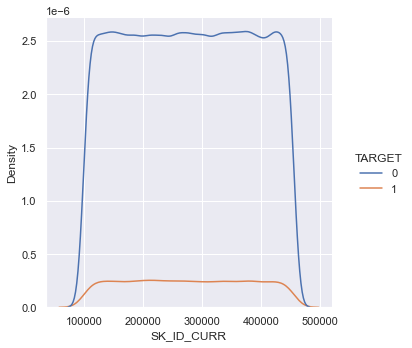

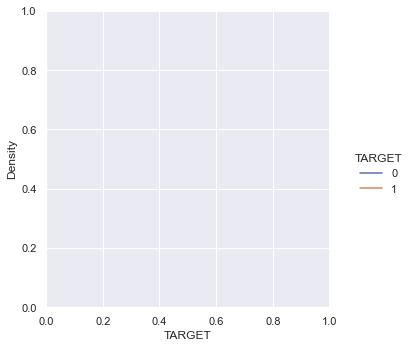

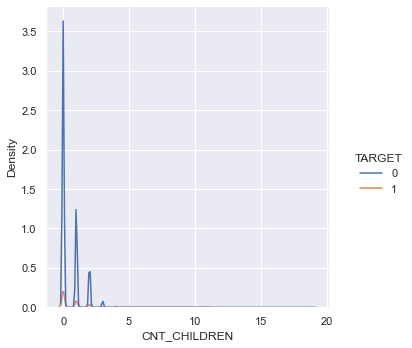

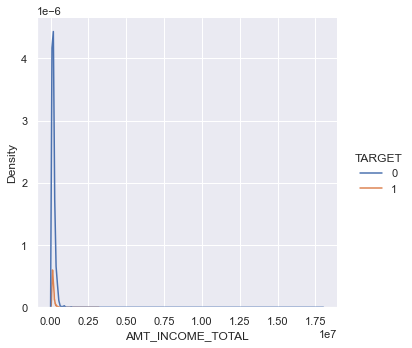

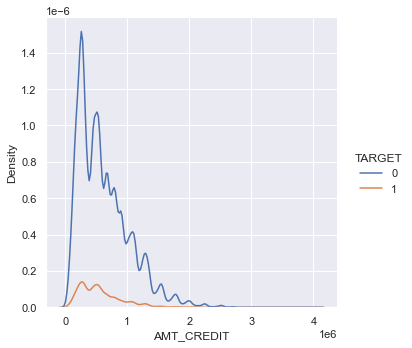

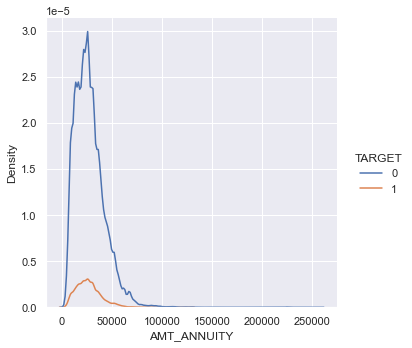

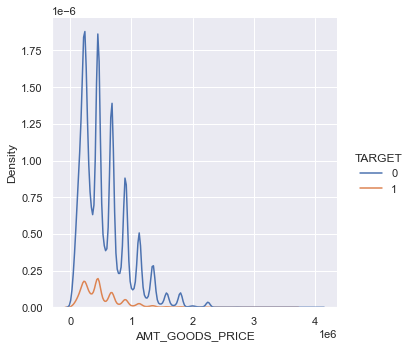

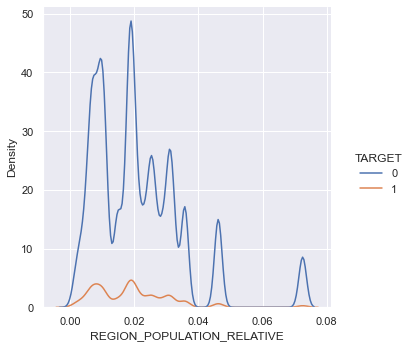

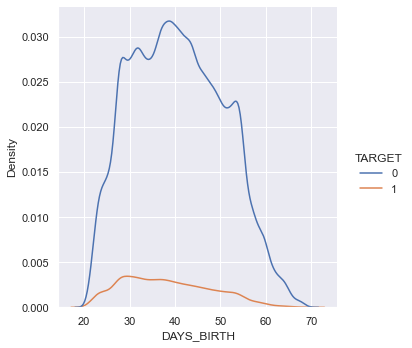

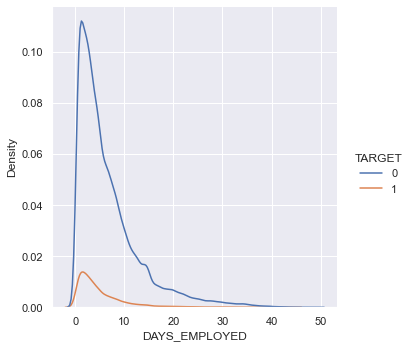

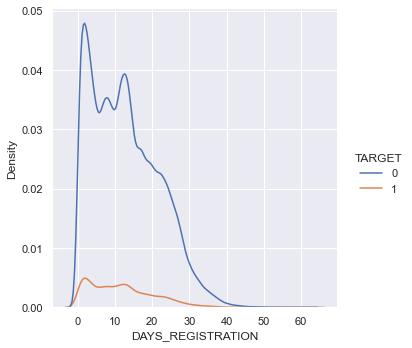

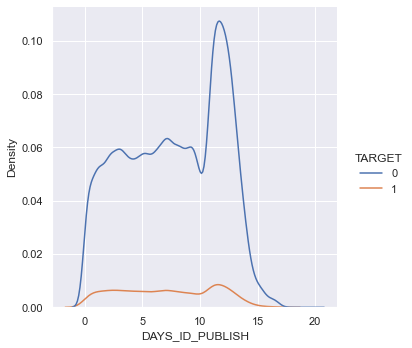

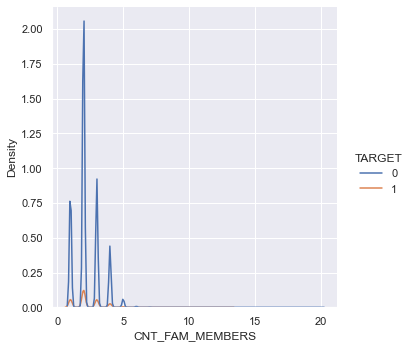

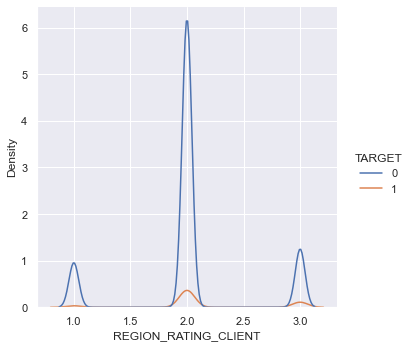

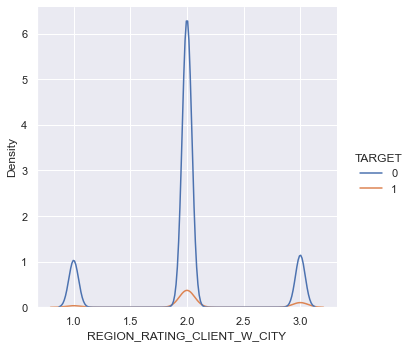

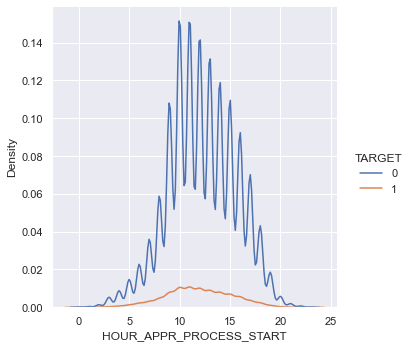

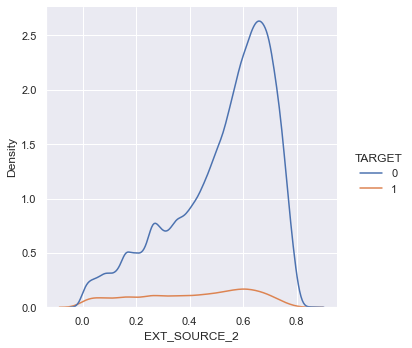

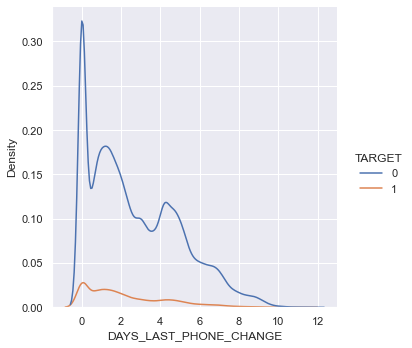

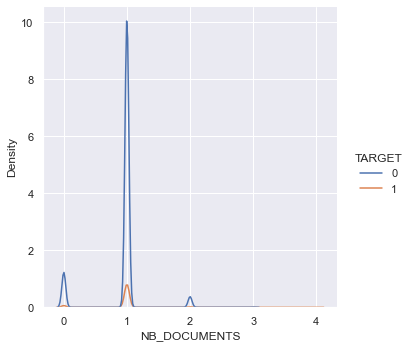

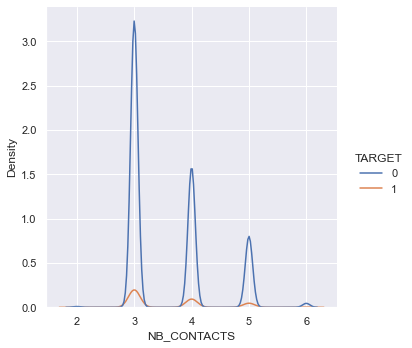

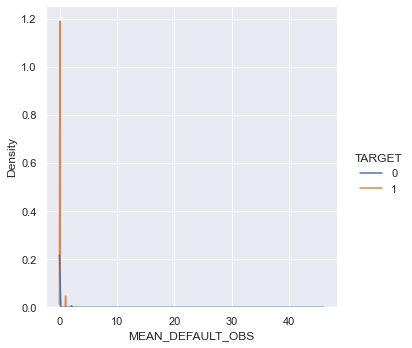

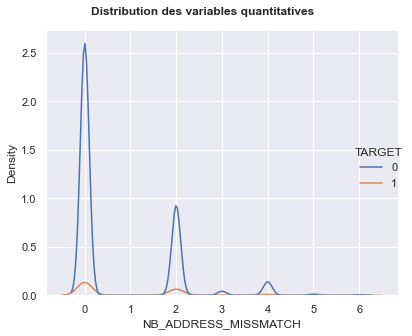

In [137]:
#Analyse des ordres de grandeur pour chaque variable target de notre mission
fig = plt.figure(figsize=(15,12))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

COL = df_train.columns

for i, col in enumerate(COL,1):
    #ax = fig.add_subplot(6,3,i)
    sns.displot(data=df_train, x=col, hue="TARGET", kind="kde")

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution des variables quantitatives', fontsize=12,
             fontweight='bold')

plt.show()

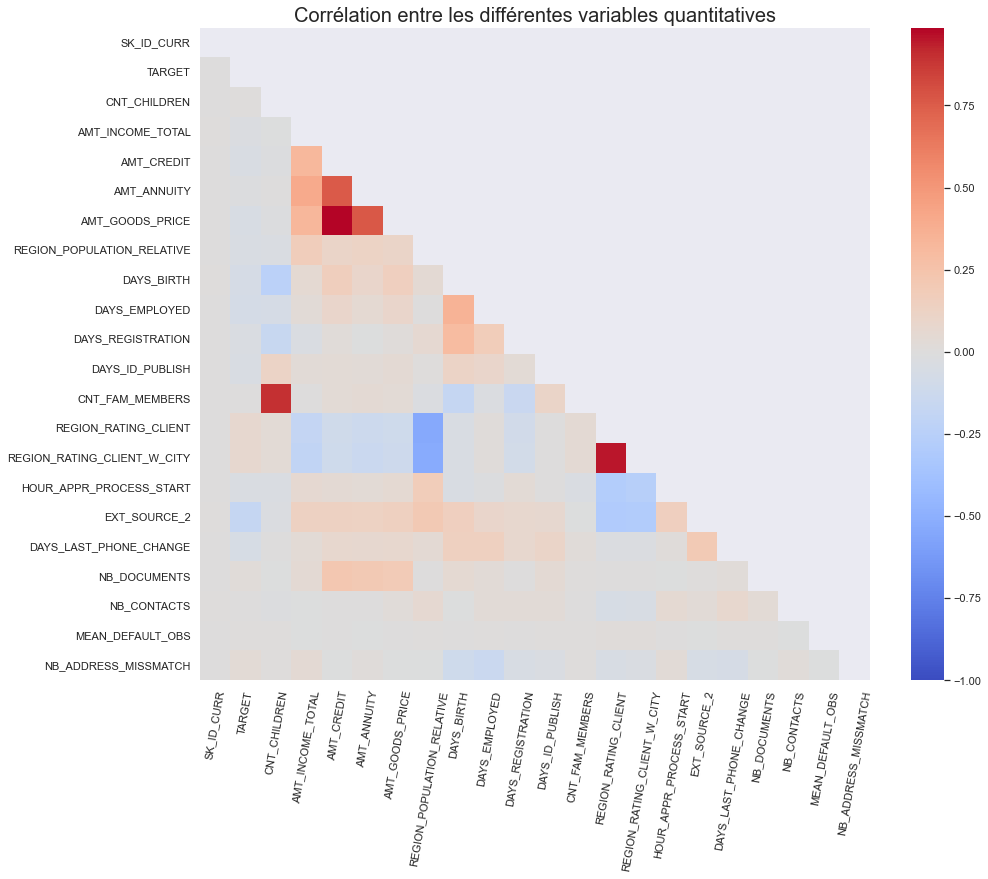

In [138]:
#Heatmap correlation entre variables quantitatives
plt.figure(figsize=(15,12))
#sns.set(font_scale=1.5)
plt.title('Corrélation entre les différentes variables quantitatives', fontsize = 20)

corr = df_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm', annot = False)
plt.xticks(rotation=80)
plt.show()
sns.set(font_scale=1)

In [139]:
#Analyse des variables a forte correlation pour prise de decision
df_train[['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']].describe()

,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
count,250518.000000,250518.000000
mean,2.045258,2.023918
std,0.512262,0.506336
min,1.000000,1.000000
25%,2.000000,2.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,3.000000,3.000000


In [140]:
#Distribution equivalente, donc suppression d'une des 2 variables
df_train.drop(['REGION_RATING_CLIENT_W_CITY'],1, inplace=True)

In [141]:
#Analyse des variables a forte correlation pour prise de decision
df_train[['CNT_FAM_MEMBERS','CNT_CHILDREN']].describe()

,CNT_FAM_MEMBERS,CNT_CHILDREN
count,250518.000000,250518.000000
mean,2.252868,0.498563
std,0.942067,0.763292
min,1.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,20.000000,19.000000


In [142]:
#Creation de nouvelles variables "metier" et supression d'une des 2 variables fortement correlees
df_train['INCOME_PER_PERSON'] = df_train['AMT_INCOME_TOTAL'] / (df_train['CNT_FAM_MEMBERS'])

In [143]:
#Distribution equivalente, donc suppression d'une des 2 variables
df_train.drop(['CNT_FAM_MEMBERS','AMT_INCOME_TOTAL'],1, inplace=True)

In [144]:
#Creation de nouvelles variables "metier" et supression d'une des 2 variables fortement correlees
df_train['CREDIT_PER_GOOD']=df_train['AMT_CREDIT']/df_train['AMT_GOODS_PRICE']
df_train['ANNUITY_PER_GOOD']=df_train['AMT_ANNUITY']/df_train['AMT_GOODS_PRICE']
df_train['YRS_WORKING_PER_BIRTH']=df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']

In [146]:
#Suppression des variables correlees non necessaires
df_train.drop(['DAYS_EMPLOYED','DAYS_BIRTH','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_CHILDREN'],1, inplace=True)

In [149]:
#Taille de la nouvelle dataframe
df_train.shape

(250518, 17)

In [150]:
#Selection des meilleurs features avec VIF - Variance Inflation Factor
df_train_vif = df_train.copy()
X = df_train_vif.drop(['SK_ID_CURR','TARGET'], axis=1)

vif_info = pd.DataFrame()

vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
12,49.560987,CREDIT_PER_GOOD
8,20.205251,NB_CONTACTS
3,18.975556,REGION_RATING_CLIENT
4,14.197000,HOUR_APPR_PROCESS_START
5,9.177337,EXT_SOURCE_2
7,8.371645,NB_DOCUMENTS
13,6.917681,ANNUITY_PER_GOOD
2,4.469107,DAYS_ID_PUBLISH
0,4.286112,REGION_POPULATION_RELATIVE
1,3.100660,DAYS_REGISTRATION


In [151]:
#Suppression des variables avec VIF sup a 5
df_train_vif.drop(['CREDIT_PER_GOOD','NB_CONTACTS','REGION_RATING_CLIENT','HOUR_APPR_PROCESS_START','EXT_SOURCE_2','NB_DOCUMENTS','ANNUITY_PER_GOOD'],1, inplace=True)

In [152]:
#Nouvelle taille du dataframe
df_train_vif.shape

(250518, 10)

In [155]:
#Sauvegarde de ce dataset simple
df_train_vif.to_csv('Dataset/df_train_simple.csv', index=False)

# <a name="C7">Creation d'un dataset basé sur le Kernel Kaggle</a>

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 29s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 26)
Process installments payments - done in 30s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797104	training's binary_logloss: 0.234829	valid_1's auc: 0.776089	valid_1's binary_logloss: 0.246759
[400]	training's auc: 0.819226	training's binary_logloss: 0.22537	valid_1's auc: 0.787159	valid_1's binary_logloss: 0.242511
[600]	training's auc: 0.834155	training's binary_logloss: 0.219277	valid_1's auc: 0.790742	valid_1

Fold  7 AUC : 0.790524
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797384	training's binary_logloss: 0.235077	valid_1's auc: 0.770478	valid_1's binary_logloss: 0.245343
[400]	training's auc: 0.819664	training's binary_logloss: 0.225542	valid_1's auc: 0.781776	valid_1's binary_logloss: 0.240982
[600]	training's auc: 0.834599	training's binary_logloss: 0.219451	valid_1's auc: 0.785968	valid_1's binary_logloss: 0.239525
[800]	training's auc: 0.846348	training's binary_logloss: 0.214629	valid_1's auc: 0.787951	valid_1's binary_logloss: 0.238904
[1000]	training's auc: 0.856847	training's binary_logloss: 0.210207	valid_1's auc: 0.788733	valid_1's binary_logloss: 0.238634
[1200]	training's auc: 0.866335	training's binary_logloss: 0.206035	valid_1's auc: 0.789318	valid_1's binary_logloss: 0.238496
[1400]	training's auc: 0.875156	training's binary_logloss: 0.202086	valid_1's auc: 0.789737	valid_1's bina

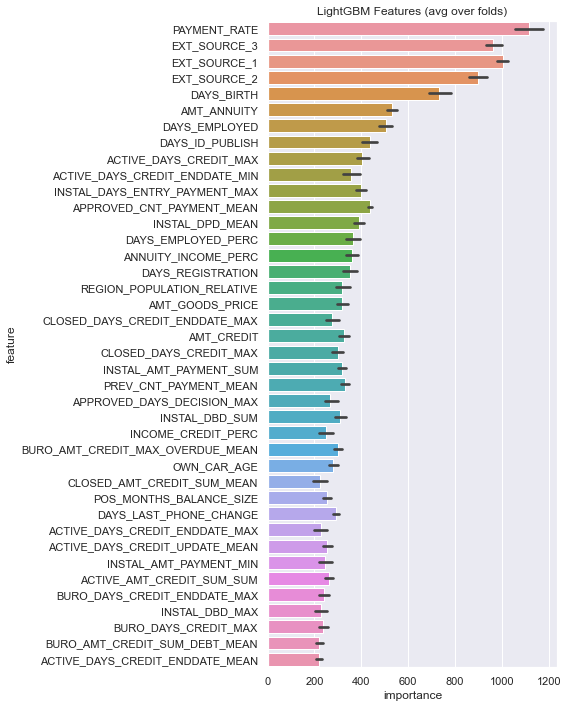

In [192]:
#Lancement des fonctions du Kernel Kaggle pour obtenir le dataset complexe (plus elabore et reflechi)
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df_train_test_kernel = main()

In [193]:
#Taille du dataset complexe
df_train_test_kernel.shape

(356251, 798)

In [194]:
#Apercu du fichier resultant
df_train_test_kernel.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZ

In [195]:
#Sauvegarde du fichier dataset complexe
df_train_test_kernel.to_csv('Dataset/df_train_test_kernel.csv', index=False)

# Partie 2 : Modélisation

In [24]:
#data = df_train_vif.copy()
data = pd.read_csv('Dataset/df_train_test_kernel.csv')
data_name = 'KERNEL'

In [25]:
#Transformation des noms de colonnes sans espaces ou caracteres speciales genants
data.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").replace(","," ").replace("["," ").replace("]"," ").replace("{"," ").replace("}"," ").replace(":"," ").upper(), data.columns))
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# <a name="C8">Echantillon et Séparation des données en train et test</a>

In [26]:
#Echnatillonage des donnees a 10%. Choix de prendre les 30000 premiers de la liste
data = data.head(30000)
data.head()

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#Definition de X(features) et y(TARGET) pour la separation des donnees
if data_name == 'KERNEL':
    train_df = data[data['TARGET'].notnull()]
    test_df = data[data['TARGET'].isnull()]
    #feats_kernel = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','index','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']]
    #X=train_df[feats_kernel]
    y=train_df['TARGET']
    list_out = ['TARGET','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']
    
    #list_out = ['TARGET','SK_ID_CURR','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']
    
    X = train_df.drop(columns = list_out) #on vire les colonnes infinies
else:
    feats = [f for f in data.columns if f not in ['TARGET','SK_ID_CURR']]
    X=data[feats]
    y=data['TARGET']

In [28]:
#Separation des donnees en entrainement et test avec un ratio de 80 20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)

# <a name="C9">Pré-traitement et modélisation</a>

### Baseline

In [201]:
#Initialisation de la dataframe Results qui contiendra le resultat des evaluations de modelisation
results = pd.DataFrame()

In [202]:
#Evaluation de la modelisation sur un Dummy Classifier
result = modelisation_baseline(X_train, y_train, "no_sampler", DummyClassifier(strategy="most_frequent"))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [203]:
#Evaluation de la modelisation sur un LogisticRegression
result = modelisation_baseline(X_train, y_train, "no_sampler", LogisticRegression())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [204]:
#Apercu des resultats - accuracy trop bon! Du au desequilibre des classes
results

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': MinMaxScaler()},0.919417,11.718119,0.922,0.000,0.000,0.000,0.500
1,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': StandardScaler()},0.919417,12.541104,0.922,0.000,0.000,0.000,0.500
2,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': RobustScaler()},0.919417,7.414871,0.922,0.000,0.000,0.000,0.500
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918583,16.357303,0.921,0.459,0.036,0.067,0.753
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.915333,17.237119,0.921,0.459,0.036,0.067,0.753
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.634875,12.565139,0.921,0.459,0.036,0.067,0.753


Pour remedier a ce desequilibre, 4 solutions sont etudiees :
- undersampling cree manuellement
- class weight balance
- SMOTE
- RandomUnderSampling

### Prétraitement avec manuel undersampling

In [205]:
#Application du sous echantillanoge manuel a nos jeux de donnees
X_tr_under, y_tr_under = undersampling_manuel(X_train, y_train)

In [206]:
#Nombre de clients par classe resultant
y_tr_under.value_counts()

0.0    1934
1.0    1934
Name: TARGET, dtype: int64

In [207]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo LogisticRegression
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", LogisticRegression())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [208]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo KNN
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", KNeighborsClassifier())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [209]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo LGBM
result = modelisation_no_sampler(X_tr_under, y_tr_under, "manual_sampler", LGBMClassifier())
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Prétraitement avec class weight balanced

In [210]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo LogisticRegression
result = modelisation_no_sampler(X_train, y_train, "class_balanced", LogisticRegression(class_weight='balanced'))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [211]:
#result = modelisation_no_sampler(X_train, y_train, "class_balanced", KNeighborsClassifier(class_weight='balanced'))
#results = results.append(result)

In [212]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo LGBM
result = modelisation_no_sampler(X_train, y_train, "class_balanced", LGBMClassifier(class_weight='balanced'))
results = results.append(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Prétraitement avec SMOTE and RandomUnderSampling

In [213]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo LogisticRegression
result = modelisation_with_sampler(X_train, y_train, "param_sampler", LogisticRegression())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [214]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo KNN
result = modelisation_with_sampler(X_train, y_train, "param_sampler", KNeighborsClassifier())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [215]:
#Evaluation et optimisation des parametres de pretraitement sur l'algo LGBM
result = modelisation_with_sampler(X_train, y_train, "param_sampler", LGBMClassifier())
pd.set_option('display.max_colwidth', -1)
results = results.append(result)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Résumé des modèles

In [216]:
#Affichage des resultats de l'optimisation des parametres de pre-traitement sur les differents algos
results

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': MinMaxScaler()},0.919417,11.718119,0.922,0.000,0.000,0.000,0.500
1,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': StandardScaler()},0.919417,12.541104,0.922,0.000,0.000,0.000,0.500
2,DummyClassifier(strategy='most_frequent'),no_sampler,{'scaler': RobustScaler()},0.919417,7.414871,0.922,0.000,0.000,0.000,0.500
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918583,16.357303,0.921,0.459,0.036,0.067,0.753
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.915333,17.237119,0.921,0.459,0.036,0.067,0.753
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.634875,12.565139,0.921,0.459,0.036,0.067,0.753
0,LogisticRegression(),manual_sampler,{'scaler': MinMaxScaler()},0.741782,2.096281,0.690,0.157,0.680,0.255,0.749
1,LogisticRegression(),manual_sampler,{'scaler': StandardScaler()},0.704420,2.102870,0.690,0.157,0.680,0.255,0.749
2,LogisticRegression(),manual_sampler,{'scaler': RobustScaler()},0.530827,1.792128,0.690,0.157,0.680,0.255,0.749
0,KNeighborsClassifier(),manual_sampler,{'scaler': MinMaxScaler()},0.580734,0.597730,0.616,0.108,0.539,0.180,0.604


In [218]:
#Affichage des resultats de l'optimisation des parametres de pre-traitement sur les differents algos classes par AUC et temps d'execution
top_results = results.sort_values(by=['auc','mean_fit_time'], ascending=[False, True])
top_results.head(15)

,estimator,sampler_type,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
2,LogisticRegression(),no_sampler,{'scaler': RobustScaler()},0.634875,12.565139,0.921,0.459,0.036,0.067,0.753
0,LogisticRegression(),no_sampler,{'scaler': MinMaxScaler()},0.918583,16.357303,0.921,0.459,0.036,0.067,0.753
1,LogisticRegression(),no_sampler,{'scaler': StandardScaler()},0.915333,17.237119,0.921,0.459,0.036,0.067,0.753
0,LogisticRegression(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': MinMaxScaler()}",0.733551,7.563689,0.724,0.166,0.631,0.263,0.751
1,LogisticRegression(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': StandardScaler()}",0.692550,8.223210,0.724,0.166,0.631,0.263,0.751
2,LogisticRegression(),param_sampler,"{'sampler': RandomUnderSampler(random_state=14), 'scaler': RobustScaler()}",0.540650,8.330139,0.724,0.166,0.631,0.263,0.751
5,LogisticRegression(),param_sampler,"{'sampler': SMOTE(random_state=14), 'scaler': RobustScaler()}",0.530004,19.498297,0.724,0.166,0.631,0.263,0.751
3,LogisticRegression(),param_sampler,"{'sampler': SMOTE(random_state=14), 'scaler': MinMaxScaler()}",0.737357,24.328104,0.724,0.166,0.631,0.263,0.751
4,LogisticRegression(),param_sampler,"{'sampler': SMOTE(random_state=14), 'scaler': StandardScaler()}",0.719100,25.950185,0.724,0.166,0.631,0.263,0.751
2,LogisticRegression(),manual_sampler,{'scaler': RobustScaler()},0.530827,1.792128,0.690,0.157,0.680,0.255,0.749


### Optimisation des hyperparametres de l'algo

In [29]:
#Le meilleur modele resulant de l'optimisation des parametres de pre-traitement appliquee aux differents algos est :
#L'algo LGBM
best_model = LGBMClassifier()

In [30]:
#Sur lequel on applique le pretraitement suivant - SimpleImputer, RobustScaler et RandomUnderSampler
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
sampler = RandomUnderSampler(random_state=14)
scaler = RobustScaler()

X_tr_imp = imputer.fit_transform(X_train)
X_te_imp = imputer.fit_transform(X_test)

X_tr_sc = scaler.fit_transform(X_tr_imp)
X_te_sc = scaler.fit_transform(X_te_imp)

X_train = pd.DataFrame(scaler.transform(X_tr_imp), 
                      index=X_train.index, 
                      columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_te_imp), 
                     index=X_test.index, 
                     columns=X_test.columns)

X_tr_samp, y_tr_samp = sampler.fit_resample(X_train, y_train)

In [31]:
#Fit du best model sur les donnees pretraitees
best_model.fit(X_tr_samp, y_tr_samp)

LGBMClassifier()

In [54]:
#Optimisation des hyperparametres de l'algo
scores = optimisation_modele(X_tr_samp, y_tr_samp, best_model)
scores

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,params,mean_test_score,mean_fit_time,accuracy,precision,recall,f1score,auc
0,LGBMClassifier(),"{'learning_rate': 1, 'n_estimators': 1000}",0.714712,14.881167,0.727,0.167,0.625,0.263,0.739
1,LGBMClassifier(),"{'learning_rate': 1, 'n_estimators': 5000}",0.714701,35.156651,0.727,0.167,0.625,0.263,0.739
2,LGBMClassifier(),"{'learning_rate': 1, 'n_estimators': 10000}",0.714803,56.417763,0.727,0.167,0.625,0.263,0.739
3,LGBMClassifier(),"{'learning_rate': 0.1, 'n_estimators': 1000}",0.732885,65.005333,0.727,0.167,0.625,0.263,0.739
4,LGBMClassifier(),"{'learning_rate': 0.1, 'n_estimators': 5000}",0.731444,113.707864,0.727,0.167,0.625,0.263,0.739
5,LGBMClassifier(),"{'learning_rate': 0.1, 'n_estimators': 10000}",0.731459,144.751541,0.727,0.167,0.625,0.263,0.739
6,LGBMClassifier(),"{'learning_rate': 0.01, 'n_estimators': 1000}",0.739979,73.471425,0.727,0.167,0.625,0.263,0.739
7,LGBMClassifier(),"{'learning_rate': 0.01, 'n_estimators': 5000}",0.735187,323.365613,0.727,0.167,0.625,0.263,0.739
8,LGBMClassifier(),"{'learning_rate': 0.01, 'n_estimators': 10000}",0.734132,529.049111,0.727,0.167,0.625,0.263,0.739


In [32]:
#Calcul des predictions sur le modele LGBM avec parametres par defaut
probability = best_model.predict_proba(X_test)
probability_default_payment = probability[:, 1]
prediction = best_model.predict(X_test)

In [33]:
#Calcul du ROC AUC
roc_auc = roc_auc_score(y_test, probability_default_payment)

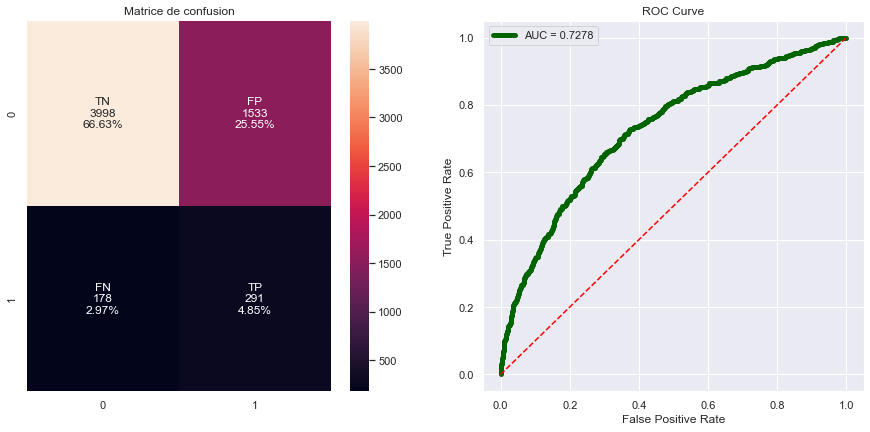

In [34]:
#Calcul des predictions de la matrice de confusion associee et visualisation de la matrice et AUC/ROC
tn, fp, fn, tp = matrice_roc_auc(y_test, prediction, probability, (15,15))

# <a name="C10">Optimisation des gains</a>

In [35]:
#% Gain de la banque avec les hypotheses de profit 10% pour les TN et perte de 60% pour les FN, et en considerant les predictions de la modelisation avec un seuil de classification de 50%
gain = gain_banque(tn, fp, fn, tp, 0.10, 0, -0.6, 0)
gain

0.6883163571000599

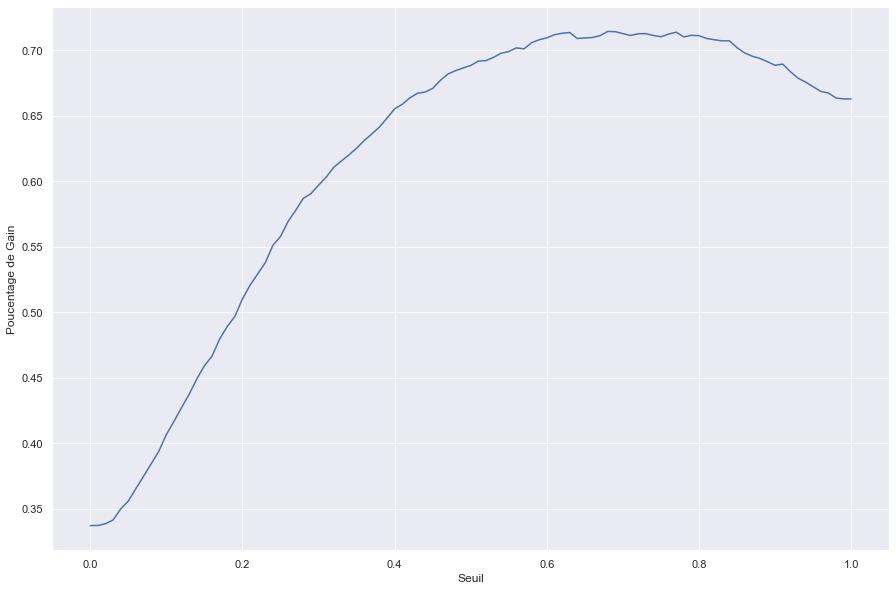

In [36]:
#Graphe qui montre l'evolution du gain de la banque en fonction du seuil de classification choisi
f_gain = []
int_seuil = np.arange(0.0, 1.01, 0.01)

for s in int_seuil:
    # Score du modèle : 0 à 1
    y_seuil=[]

    for i in probability_default_payment:
        if i >= s:
            y_seuil.append(1)
        elif i < s:
            y_seuil.append(0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()
  
    f_gain.append(gain_banque(tn, fp, fn, tp, 0.10, 0, -0.6, 0))
    
# Affichage du gain en fonction du seuil de solvabilité  
plt.figure(figsize=(15, 10))
df_gain = pd.DataFrame()
df_gain['seuil'] = int_seuil
df_gain['gain'] =  f_gain
best_gain = df_gain['gain'].max()
best_seuil = df_gain[df_gain['gain']==best_gain]['seuil'].values[0]
plt.plot(int_seuil, f_gain)
plt.xlabel("Seuil")
plt.ylabel("Poucentage de Gain")
plt.show()

In [37]:
#Determination du meilleur seuil
best_seuil = df_gain[df_gain['gain']==best_gain]['seuil'].values[0]
best_seuil

0.68

# <a name="C11">Interprétabilité du modèle</a>

In [38]:
#Renommage des colonnes pour meilleure comprehension des variables sur le dashboard
info_cols = {
            'CODE_GENDER': "GENRE",
            'DAYS_BIRTH': "AGE",
            'NAME_FAMILY_STATUS': "STATUT FAMILIAL", 
            'CNT_CHILDREN': "NB ENFANTS",
            'FLAG_OWN_CAR': "PROPRIETAIRE VEHICULE",
            'FLAG_OWN_REALTY': "PROPRIETAIRE IMMOBILIER",
            'NAME_EDUCATION_TYPE': "NIVEAU EDUCATION",
            'OCCUPATION_TYPE': "OCCUPATION", 
            'DAYS_EMPLOYED': "NB ANNEES EMPLOI",
            'AMT_INCOME_TOTAL': "REVENUS",
            'AMT_CREDIT': "MONTANT CREDIT", 
            'NAME_CONTRACT_TYPE': "TYPE CONTRAT",
            'AMT_ANNUITY': "MONTANT ANNUITES",
            'NAME_INCOME_TYPE': "TYPE REVENUS",
            'EXT_SOURCE_1': "SCORE SOURCE 1",
            'EXT_SOURCE_2': "SCORE SOURCE 2",
            'EXT_SOURCE_3': "SCORE SOURCE 3",
            'INSTAL_DPD_MEAN' : "MOY DELAI PAIEMENT",
            'PAYMENT_RATE' : "TAUX PAIEMENT",
            'INSTAL_AMT_INSTALMENT_MEAN' : "DUREE MOYENNE CREDIT",
            'OWN_CAR_AGE' : "AGE VEHICULE",
            'APPROVED_CNT_PAYMENT_MEAN' : "MOYENS PAIEMENT",
            'ANNUITY_INCOME_PERC' : "% ANNUITE REVENU"
                }

In [39]:
#Application du renommage sur notre jeu de donnees avec feature
X.rename(columns=info_cols, inplace=True)

In [40]:
#Limitation aux 100 premiers clients de la liste pour le calcul du SHAP local - pour assurer un affichage rapide.
X_reduced = X.head(100)

### Interpretation globale

In [41]:
#Calcul des valeurs SHAP globales
explainer = shap.TreeExplainer(best_model)
shap_values_g = explainer.shap_values(X)
shap_values_g

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[array([[-0.02220945,  0.        ,  0.04824055, ...,  0.        ,
          0.        ,  0.        ],
        [-0.06450883,  0.        ,  0.04565408, ...,  0.        ,
          0.        ,  0.        ],
        [-0.12668442,  0.        ,  0.07761397, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.05201522,  0.        ,  0.07055424, ...,  0.        ,
          0.        ,  0.        ],
        [-0.09500616,  0.        ,  0.06937538, ...,  0.        ,
          0.        ,  0.        ],
        [-0.1058591 ,  0.        ,  0.06365667, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.02220945,  0.        , -0.04824055, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.06450883,  0.        , -0.04565408, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.12668442,  0.        , -0.07761397, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.05201522,  0.        , -0.07055424, ...,  

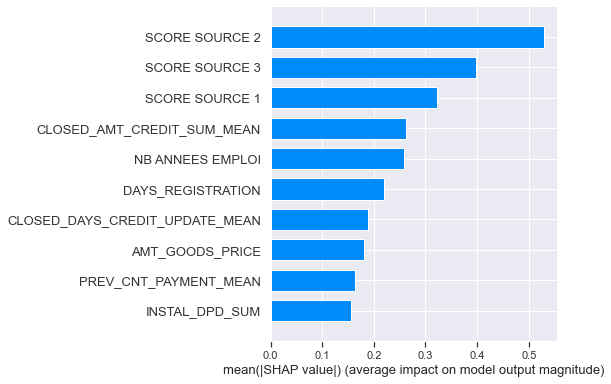

In [42]:
#Affciahge des variables les plus influentes sur la prediction
fig = plt.figure( )
shap.summary_plot(shap_values_g[0], plot_type = 'bar', feature_names = X.columns, max_display=10)
fig.savefig('Objects/global_feature_importance.png', bbox_inches='tight', dpi=150)
plt.show()

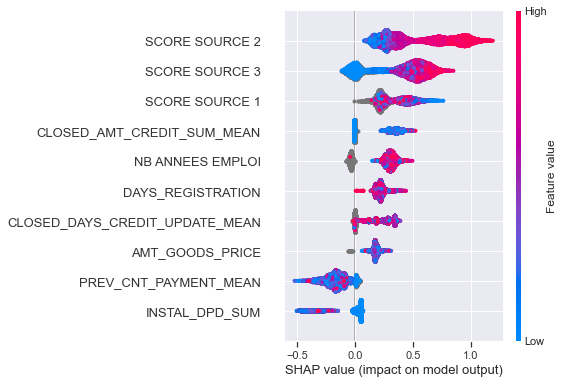

In [43]:
#Affciahge des variables les plus influentes sur la prediction
shap.summary_plot(shap_values_g[0], X.astype("float"),max_display=10, show=False)

### Interpretation locale

In [44]:
#Computation of SHAP values
explainer = shap.Explainer(best_model, X_reduced)
shap_values_l = explainer(X_reduced, check_additivity=False)
shap_values_l

.values =
array([[-2.73315053e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.47875762e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.47875762e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.47875762e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.95163661e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.82625260e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([-1.07609632, -1.07609632, -1.07609632, -1.07609632, -1.07609632,
       -1.07609632, -1.07609632, -1.07609632, -1.07609632, -1.07609632,
       -1.07609632, -1.07609632, -1.07609632, -1.07609632, -1.07609632,
 

In [45]:
#Activation de SHAP pour la generation de certains graphes
shap.initjs()

In [50]:
#Affichage des variables les plus influentes sur la prediction du client 4 sous forme de force plot
shap.force_plot(explainer.expected_value, shap_values_l.values[4, :], X_reduced.iloc[3, :])

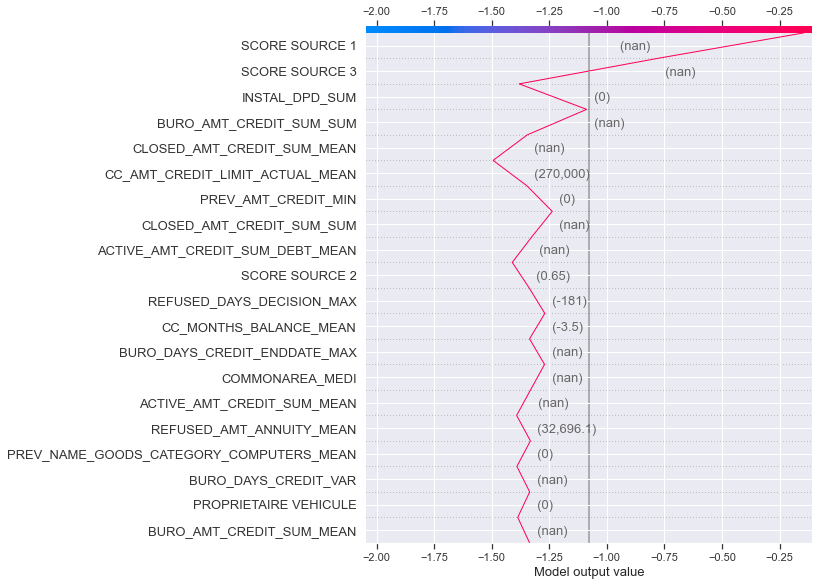

In [51]:
#Affichage des variables les plus influentes sur la prediction du client 4 sous forme de decision plot
shap.decision_plot(explainer.expected_value, shap_values_l.values[3, :], X_reduced.iloc[3, :])

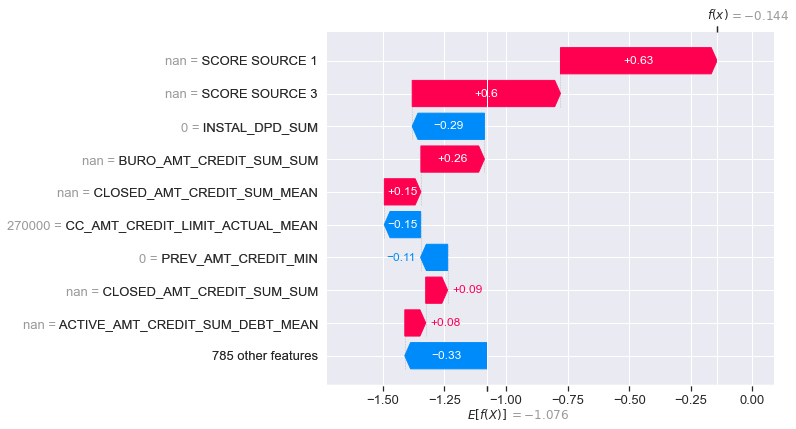

In [52]:
#Affichage des variables les plus influentes sur la prediction du client 4 sous forme de waterfall
shap.waterfall_plot(shap_values_l[3])

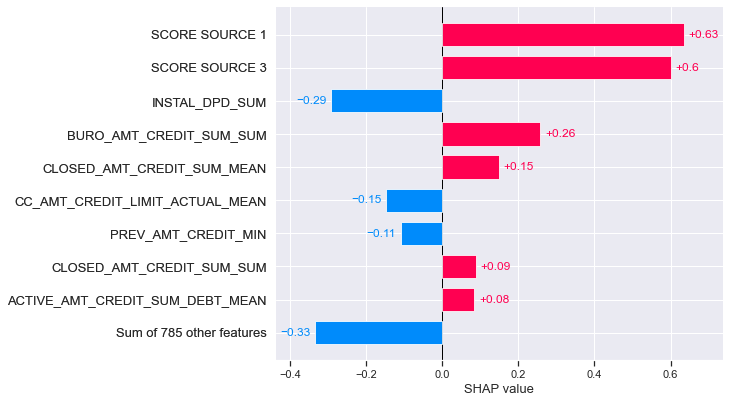

In [53]:
#Affichage des variables les plus influentes sur la prediction du client 4 sous forme de barplot
shap.plots.bar(shap_values_l[3])

# Partie 3 : Dashboard

# <a name="C12">Déploiement du modèle</a>

In [248]:
#Sauvegarde du meilleur modele
pickle.dump(best_model, open("Objects/best_model.pkl", "wb"))

In [250]:
#Sauvegarde du seuil optimum
pickle.dump(best_seuil, open("Objects/best_threshold.pkl", "wb"))

In [251]:
#Sauvegarde du data_train reduit aux 100 premiers clients - pour affichage des infos clients
df_train_or = df_train_or.head(100)
df_train_or.to_csv('Dataset/df_train_reduced.csv', index=False)

In [252]:
#Sauvegarde du dataset complexe reduit aux 100 premiers clients - pour prediction et interpretation du score
data = data.head(100)
data.to_csv('Dataset/df_kernel_reduced.csv', index=False)

In [253]:
#The end of the notebook